Babak Bayani (12347302)

Arash Behaein - (12324255)

Aditi

Jule

## necessary libraries

In [198]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
import time
warnings.filterwarnings('ignore')

# Preprocessing and Visualization:

1. As we can ignore label_category and label_vector columns as the first step I think we can remove these two columns.
2. Based on the split column in both datasets we can split the datasets to training and test sets.
3. choosing to work on full dataset or the annotated one

## Step 1: Initial Exploration

### 1.1 Loading and Inspecting the Data

In [204]:
# Load the dataset
DF=pd.read_csv('edos_labelled_aggregated.csv')

# Display the first few rows
DF.head()

,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,none,none,dev
1,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,none,none,train
2,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,none,none,train
3,sexism2022_english-13021,woman?,not sexist,none,none,train
4,sexism2022_english-966,I bet she wished she had a gun,not sexist,none,none,dev


### 1.2 Check Column Data Types

In [207]:
DF.dtypes

rewire_id         object
text              object
label_sexist      object
label_category    object
label_vector      object
split             object
dtype: object

### 1.3 Review for Missing Values

In [210]:
DF.isnull().sum()

rewire_id         0
text              0
label_sexist      0
label_category    0
label_vector      0
split             0
dtype: int64

Dropping unnecessary columns as was mentioned in task description

In [213]:
DF=DF.drop(columns=['label_category','label_vector'])
# Display the first few rows
DF.head()

,rewire_id,text,label_sexist,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,dev
1,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,train
2,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,train
3,sexism2022_english-13021,woman?,not sexist,train
4,sexism2022_english-966,I bet she wished she had a gun,not sexist,dev


In [215]:
# Binary encoding of 'label_sexist' column
DF['label_sexist'] = DF['label_sexist'].apply(lambda x: 1 if x == 'sexist' else 0)
DF.head()

,rewire_id,text,label_sexist,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",0,dev
1,sexism2022_english-16993,"Then, she's a keeper. 😉",0,train
2,sexism2022_english-13149,This is like the Metallica video where the poo...,0,train
3,sexism2022_english-13021,woman?,0,train
4,sexism2022_english-966,I bet she wished she had a gun,0,dev


For this particular project, it’s fine to perform text cleaning and label encoding before splitting because these operations don’t introduce any bias into the data and the reason for that is that:

Text Cleaning: Lowercasing and removing special characters are basic preprocessing steps that make the data more uniform. These transformations don't depend on the dataset split and won’t introduce information leakage.

Label Encoding: Similarly, converting labels to binary format doesn’t rely on any specific data characteristics and won't cause leakage.

Since we’re not using any features derived from specific parts of the data or creating new columns based on statistical properties, doing these steps at the full-dataset level is safe. After preprocessing, the split column will allow us to divide the data as originally intended for training, development, and testing.

In [218]:
# Basic text cleaning
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning
DF['text'] = DF['text'].apply(clean_text)

# Display the first few rows of the processed data
DF.head()

,rewire_id,text,label_sexist,split
0,sexism2022_english-9609,in nigeria if you rape a woman the men rape yo...,0,dev
1,sexism2022_english-16993,then shes a keeper,0,train
2,sexism2022_english-13149,this is like the metallica video where the poo...,0,train
3,sexism2022_english-13021,woman,0,train
4,sexism2022_english-966,i bet she wished she had a gun,0,dev


To Avoid data leakage, it is best to do the data exploration and visualization on the training set only, as using only training set prevents looking into test and development sets which should be saved for evaluating the performance of our trained model.

Also visualizing the training set gives us insight which is directly related to training the model, insights such as imbalance, text length and common words patterns which can guide usin any decisions and other possible preprocessing steps. 

so in the next step we are going to define our training, test and development sets based on split column and the continue our steps on training set.

In [220]:
# Filter the dataset to training, test and development sets:
DF_train = DF[DF['split']=='train']
DF_dev = DF[DF['split']=='dev']
DF_test = DF[DF['split']=='test']

# remove split column
DF_train=DF_train.drop(columns=['split'])
DF_dev=DF_dev.drop(columns=['split'])
DF_test=DF_test.drop(columns=['split'])

# Display the sizes of each set
print("Training set size:", len(DF_train))
print("Development set size:", len(DF_dev))
print("Test set size:", len(DF_test))

# Verify the Datas
display(DF_train.head())
display(DF_dev.head())
display(DF_test.head())

Training set size: 14000
Development set size: 2000
Test set size: 4000


,rewire_id,text,label_sexist
1,sexism2022_english-16993,then shes a keeper,0
2,sexism2022_english-13149,this is like the metallica video where the poo...,0
3,sexism2022_english-13021,woman,0
5,sexism2022_english-14998,unlicensed day care worker reportedly tells co...,0
6,sexism2022_english-7228,user leg day is easy hot girls who wear minisk...,1


,rewire_id,text,label_sexist
0,sexism2022_english-9609,in nigeria if you rape a woman the men rape yo...,0
4,sexism2022_english-966,i bet she wished she had a gun,0
9,sexism2022_english-3553,i agree with that but at the same time i know ...,1
15,sexism2022_english-13328,democrats from minnesota leftist muzzie shitho...,1
29,sexism2022_english-81,texas jury sentences jordanian immigrant to de...,0


,rewire_id,text,label_sexist
21,sexism2022_english-845,fuck the niggers and the jews both have a hist...,0
27,sexism2022_english-6629,well then good because someone has to knock he...,1
35,sexism2022_english-17573,usa texas islam muslims islamization sharialaw...,0
38,sexism2022_english-10268,yes normal women want to be dominated social s...,1
44,sexism2022_english-10735,she didnt have to be a bitch about it she lite...,1


## Step 3: Data Exploration and Visualization

### 3.1 Label Distribution
Checking the distribution of sexist vs. not sexist labels helps us understand if the dataset is balanced.

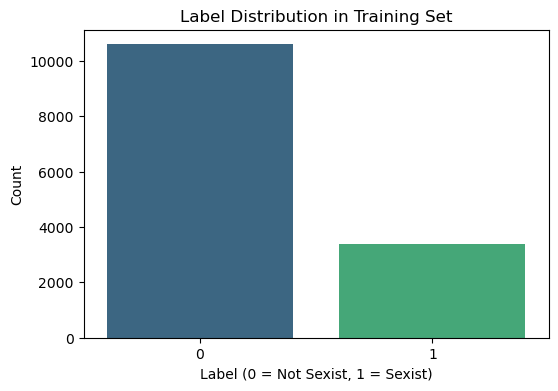

In [225]:
# Plot label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label_sexist', data=DF_train, palette='viridis')
plt.title('Label Distribution in Training Set')
plt.xlabel('Label (0 = Not Sexist, 1 = Sexist)')
plt.ylabel('Count')
plt.show()

This bar plot shows the distribution of labels (0 for non-sexist and 1 for sexist) in the training set. As we can see, the dataset is imbalanced, with significantly more non-sexist comments (label 0) than sexist comments (label 1). This imbalance is important to keep in mind, as it may affect the model's ability to detect sexist content.

knowing this we can use techniques like class weight and over/under sampling in the training phase of our model to reach better results.


### 3.2 Text Length Analysis
Analyzing text length (e.g., word or character count) can help us understand the typical length of comments in this dataset.

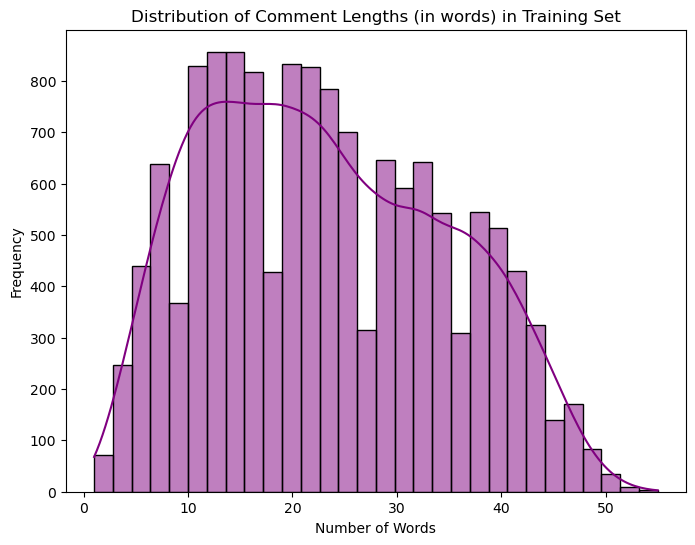

In [229]:
# Calculate text length (in words) for each comment
DF_train['text_length'] = DF_train['text'].apply(lambda x: len(x.split()))

# Plot text length distribution
plt.figure(figsize=(8, 6))
sns.histplot(DF_train['text_length'], bins=30, kde=True, color='purple')
plt.title('Distribution of Comment Lengths (in words) in Training Set')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

This histogram depicts the distribution of comment lengths in terms of word count. The majority of comments appear to be around 10–30 words long, with a gradual decrease in frequency for longer comments. This information can help inform decisions about input length settings for models and preprocessing.

### 3.3 Word Cloud
Creating a word cloud for each class (sexist and not sexist) provides a visual of common words in each label.

In [233]:
#Use if needed
#!pip install wordcloud

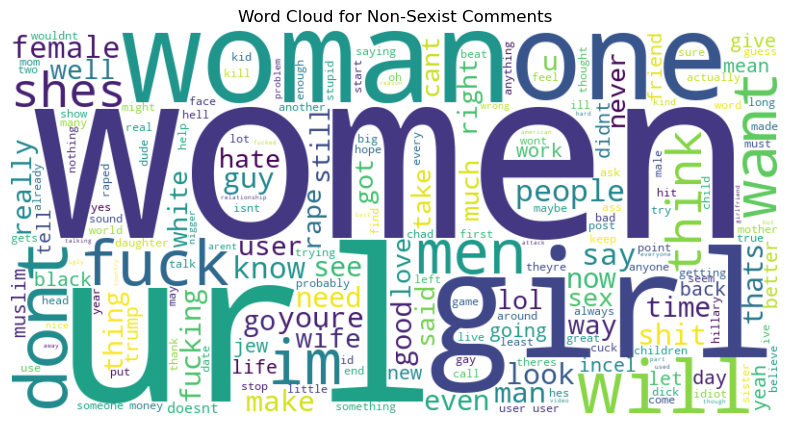

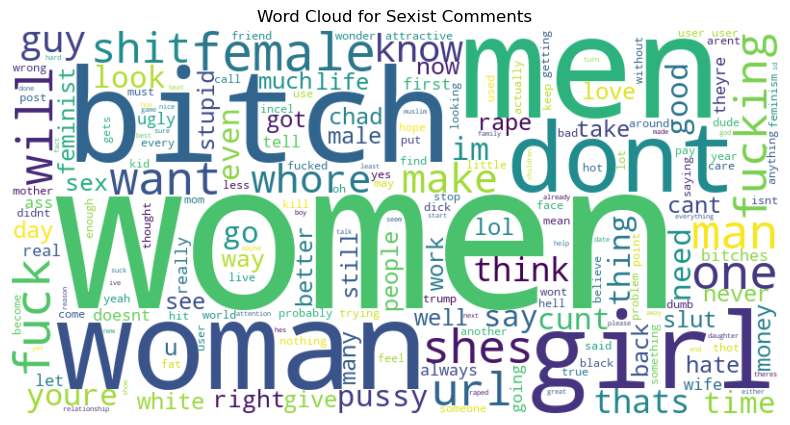

In [235]:
from wordcloud import WordCloud

# Word cloud for non-sexist comments
non_sexist_text = ' '.join(DF_train[DF_train['label_sexist'] == 0]['text'])
wordcloud_non_sexist = WordCloud(width=800, height=400, background_color='white').generate(non_sexist_text)

# Plot word cloud for non-sexist comments
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_sexist, interpolation='bilinear')
plt.title('Word Cloud for Non-Sexist Comments')
plt.axis('off')
plt.show()

# Word cloud for sexist comments
sexist_text = ' '.join(DF_train[DF_train['label_sexist'] == 1]['text'])
wordcloud_sexist = WordCloud(width=800, height=400, background_color='white').generate(sexist_text)

# Plot word cloud for sexist comments
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_sexist, interpolation='bilinear')
plt.title('Word Cloud for Sexist Comments')
plt.axis('off')
plt.show()


Word Cloud for Non-Sexist Comments: This will highlight the most frequent words in non-sexist comments, helping you understand common vocabulary and topics in this category.

Word Cloud for Sexist Comments: Similarly, this will display the most common words in sexist comments, which could provide insights into the language patterns often associated with sexism.

### 3.4 N-gram Analysis
N-gram analysis (e.g., bigrams) can reveal common phrases within each class.

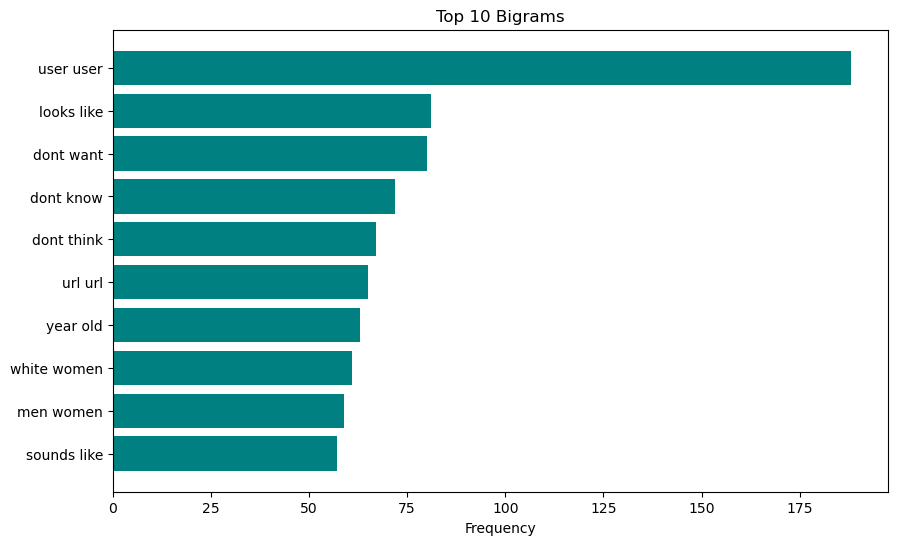

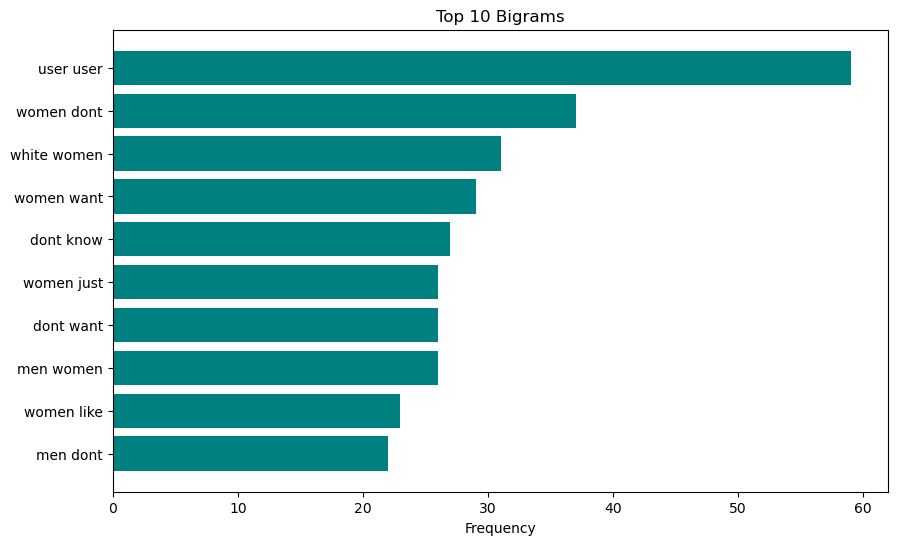

In [238]:
# Function to plot top n-grams
def plot_top_ngrams(corpus, n_gram_range=(2, 2), top_n=10):
    vec = CountVectorizer(ngram_range=n_gram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_words = words_freq[:top_n]
    
    x, y = zip(*top_words)
    plt.figure(figsize=(10, 6))
    plt.barh(x, y, color='teal')
    plt.xlabel('Frequency')
    plt.title(f'Top {top_n} {"Bigrams" if n_gram_range == (2, 2) else "Trigrams"}')
    plt.gca().invert_yaxis()
    plt.show()

# Plot top bigrams for non-sexist comments
plot_top_ngrams(DF_train[DF_train['label_sexist'] == 0]['text'], n_gram_range=(2, 2), top_n=10)

# Plot top bigrams for sexist comments
plot_top_ngrams(DF_train[DF_train['label_sexist'] == 1]['text'], n_gram_range=(2, 2), top_n=10)

This bar plot displays the most common bigrams (two-word combinations) in the dataset. It provides insight into recurring phrases and patterns. Some bigrams, like "user user" and "url url," might be artifacts or noise. These could potentially be removed during further text cleaning if they are irrelevant for detecting sexism.

### Saving the Preprocessed Data

In [244]:
# Saving DataFrame to CSV file 
DF.to_csv('DF_train.csv', index=False)
DF.to_csv('DF_dev.csv', index=False)
DF.to_csv('DF_test.csv', index=False)